In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c hse-recommender-systems-course-challenge-2023

 98% 86.0M/87.6M [00:04<00:00, 26.5MB/s]
100% 87.6M/87.6M [00:04<00:00, 19.0MB/s]


In [ ]:
!unzip hse-recommender-systems-course-challenge-2023

Archive:  hse-recommender-systems-course-challenge-2023.zip
  inflating: sample_submission.csv   
  inflating: testset                 
  inflating: training                


In [ ]:
import sys
import copy
import torch
import random
import numpy as np
from collections import defaultdict
from multiprocessing import Process, Queue
import time
import os

import model as models
from utils import *
from loss_topk import *
from plot import *

import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn

# Preparing data

In [ ]:
new_path, user_map, item_map = convert_dataset('/content/training')

In [ ]:
config = CONFIG(dataset=new_path, num_epochs=5,
                device='cuda', batch_size=128,
                dropout_rate=0.2, num_heads=4,
                num_blocks=8, lr=5e-3, hidden_units=64, maxlen=30)
np.random.seed(123)

In [ ]:
dataset = data_partition(config.dataset, header=True)

In [ ]:
[user_train, user_valid, user_test, usernum, itemnum] = dataset

In [ ]:
if not os.path.isdir(config.dataset + '_' + config.train_dir):
    os.makedirs(config.dataset + '_' + config.train_dir)
with open(os.path.join(config.dataset + '_' + config.train_dir, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(config).items(), key=lambda x: x[0])]))
f.close()


In [ ]:
num_batch = len(user_train) // config.batch_size # tail? + ((len(user_train) % args.batch_size) != 0)
cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))

f = open(os.path.join(config.dataset + '_' + config.train_dir, 'log.txt'), 'w')

sampler = WarpSampler(user_train, usernum, itemnum, batch_size=config.batch_size, maxlen=config.maxlen, n_workers=3)

average sequence length: 90.68


# Fitting models

In [ ]:
sasrec = models.SASRec(usernum, itemnum, config)

In [ ]:
sasrec.dev

'cuda'

In [ ]:
for name, param in sasrec.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

In [ ]:

sasrec.train() # enable model training

epoch_start_idx = 1
if config.state_dict_path is not None:
    try:
        sasrec.load_state_dict(torch.load(config.state_dict_path, map_location=torch.device(config.device)))
        tail = config.state_dict_path[config.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(config.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()


if config.inference_only:
    sasrec.eval()
    t_test = evaluate(sasrec, dataset, config)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

In [ ]:
from collections import defaultdict

In [ ]:
criterion_names = {"bce": torch.nn.BCEWithLogitsLoss(), "top1": top1_loss, "top1-max": top1_max_loss, "bpr-max": bpr_max_loss}
loss_history = defaultdict(lambda: defaultdict(list))
ndcg_history = defaultdict(lambda: defaultdict(list))
hr_history = defaultdict(lambda: defaultdict(list))

T = 0.0
t0 = time.time()
for criterion_name in criterion_names:
    del sasrec
    print(criterion_name)
    criterion = criterion_names[criterion_name]
    print(criterion)
    sampler = WarpSampler(user_train, usernum, itemnum, batch_size=config.batch_size, maxlen=config.maxlen, n_workers=3)
    sasrec = models.SASRec(usernum, itemnum, config)
    sasrec.item_emb = sasrec.item_emb.to(config.device)
    sasrec.pos_emb = sasrec.pos_emb.to(config.device)
    sasrec.attention_layernorms = sasrec.attention_layernorms.to(config.device)
    sasrec.attention_layers = sasrec.attention_layers.to(config.device)
    sasrec.forward_layernorms = sasrec.forward_layernorms.to(config.device)
    sasrec.forward_layers = sasrec.forward_layers.to(config.device)
    sasrec.last_layernorm = sasrec.last_layernorm.to(config.device)
    sasrec.train()
    adam_optimizer = torch.optim.Adam(sasrec.parameters(), lr=config.lr, betas=(0.9, 0.98))
    for epoch in range(epoch_start_idx, config.num_epochs + 1):
        if config.inference_only: break # just to decrease identition
        for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
            u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
            u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
            pos_logits, neg_logits = sasrec(u, seq, pos, neg)
            pos_labels, neg_labels = torch.ones(pos_logits.shape, device=config.device), torch.zeros(neg_logits.shape, device=config.device)
            # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
            adam_optimizer.zero_grad()
            indices = np.where(pos != 0)
            if criterion_name == "bce":
                loss = criterion(pos_logits[indices], pos_labels[indices])
                loss += criterion(neg_logits[indices], neg_labels[indices])
            elif criterion_name == "top1":
                loss = criterion(pos_logits[indices], neg_logits[indices])
            else:
                loss = criterion(pos_logits[indices], neg_logits[indices], F.softmax(neg_logits, dim=1)[indices])
            for param in sasrec.item_emb.parameters(): loss += config.l2_emb * torch.norm(param)
            loss.backward()
            adam_optimizer.step()
            loss_history[criterion_name][epoch].append(loss.item())
            print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs


        if epoch % 1 == 0:
            sasrec.eval()
            t1 = time.time() - t0
            T += t1
            print('Evaluating', end='')
            t_test = evaluate(sasrec, dataset, config)
            #t_valid = evaluate_valid(sasrec, dataset, config)
            #print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f), test (NDCG@10: %.4f, HR@10: %.4f)'
            #        % (epoch, T, t_valid[0], t_valid[1], t_test[0], t_test[1]))
            ndcg_history[criterion_name][epoch].append(t_test[0])
            hr_history[criterion_name][epoch].append(t_test[1])

            '''f.write(str(t_valid) + ' ' + str(t_test) + '\n')
            f.flush()'''
            t0 = time.time()
            sasrec.train()
'''
        if epoch == config.num_epochs:
            folder = config.dataset + '_' + config.train_dir
            fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
            fname = fname.format(config.num_epochs, config.lr, config.num_blocks, config.num_heads, config.hidden_units, config.maxlen)
            torch.save(sasrec.state_dict(), os.path.join(folder, fname))
            '''

Выходные данные были обрезаны до нескольких последних строк (5000).
loss in epoch 5 iteration 968: 0.020260512828826904
loss in epoch 5 iteration 969: 0.019347185268998146
loss in epoch 5 iteration 970: 0.017922203987836838
loss in epoch 5 iteration 971: 0.018153000622987747
loss in epoch 5 iteration 972: 0.018100768327713013
loss in epoch 5 iteration 973: 0.01899709366261959
loss in epoch 5 iteration 974: 0.018022755160927773
loss in epoch 5 iteration 975: 0.016779383644461632
loss in epoch 5 iteration 976: 0.019339576363563538
loss in epoch 5 iteration 977: 0.016134727746248245
loss in epoch 5 iteration 978: 0.019817281514406204
loss in epoch 5 iteration 979: 0.021012987941503525
loss in epoch 5 iteration 980: 0.019359827041625977
loss in epoch 5 iteration 981: 0.01723708212375641
loss in epoch 5 iteration 982: 0.021450772881507874
loss in epoch 5 iteration 983: 0.020756343379616737
loss in epoch 5 iteration 984: 0.019511869177222252
loss in epoch 5 iteration 985: 0.02067687734961509

"\n        if epoch == config.num_epochs:\n            folder = config.dataset + '_' + config.train_dir\n            fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'\n            fname = fname.format(config.num_epochs, config.lr, config.num_blocks, config.num_heads, config.hidden_units, config.maxlen)\n            torch.save(sasrec.state_dict(), os.path.join(folder, fname))\n            "

# Plotting

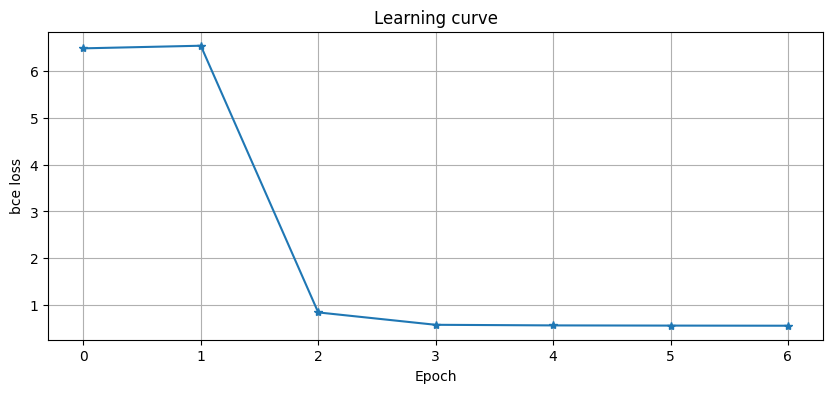

In [ ]:
plot_loss('bce', loss_history)

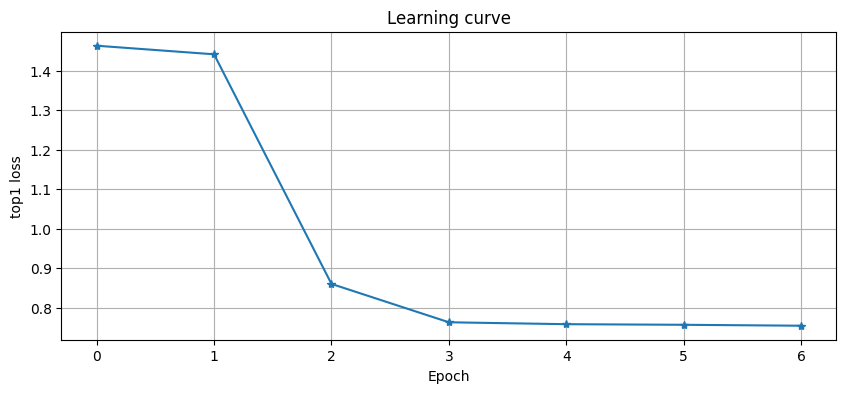

In [ ]:
plot_loss('top1', loss_history)

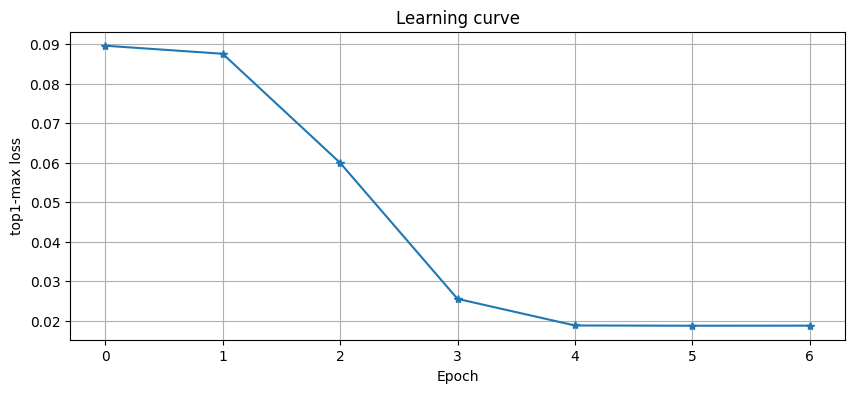

In [ ]:
plot_loss('top1-max', loss_history)

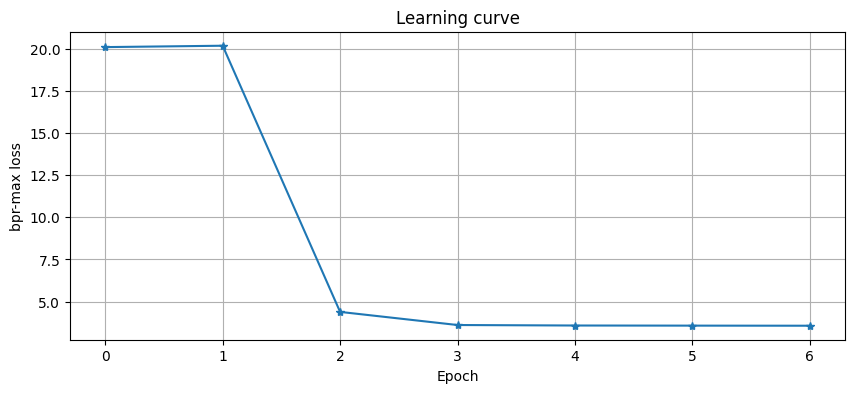

In [ ]:
plot_loss('bpr-max', loss_history)

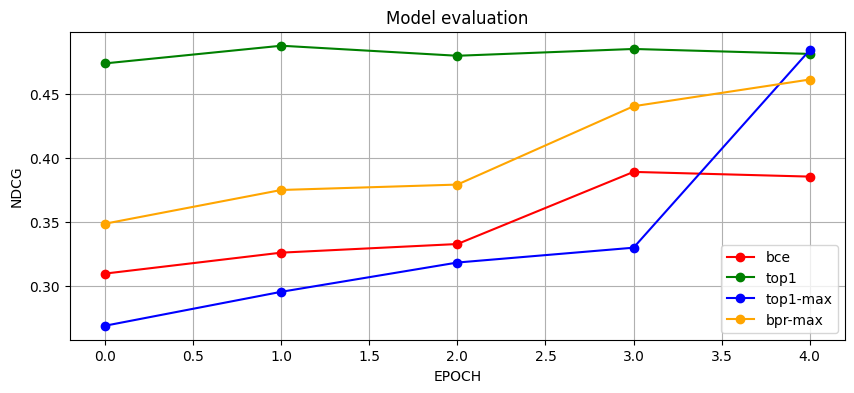

In [ ]:
plot_metric(ndcg_history, "NDCG")

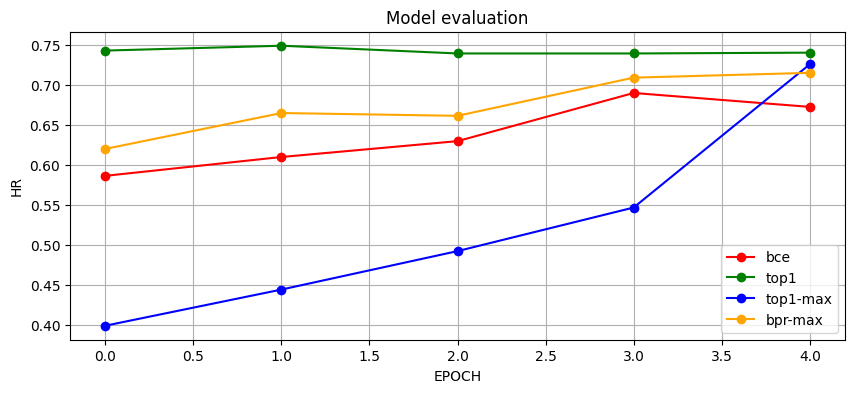

In [ ]:
plot_metric(hr_history, "HR")

# Submit to kaggle

In [ ]:
test = pd.read_csv('testset')

test.head()

,userid,movieid,rating,timestamp
0,55,1631,3.5,1274778835
1,55,493,1.0,1274781574
2,55,945,4.0,1301556480
3,55,2072,1.5,1274781305
4,55,2073,4.5,1274781645


In [ ]:
users_test = test.userid.unique()
usernum_test = len(users_test)

usertest_map = dict(zip(users_test, range(1, usernum_test+1)))
test['userid_mapped'] = test['userid'].map(usertest_map)
test['movieid_mapped'] = test['movieid'].map(item_map)

User_test = {i:test[test['userid_mapped'] == i]['movieid_mapped'].to_list() for i in range(1, usernum_test+1)}

In [ ]:
usertest_map_reversed = dict(zip(usertest_map.values(), usertest_map.keys()))

In [ ]:
item_map_reversed = dict(zip(item_map.values(), item_map.keys()))

In [ ]:
def create_seq(user, u, maxlen=50):
    lst = user[u][-maxlen:]
    if len(lst) < 50:
        lst = [0]* (maxlen - len(lst)) + lst
    return lst

In [ ]:
df_tosub = {'userid': [],
            'movieid': []}

sasrec.eval()

for i in range(1, usernum_test+1):
    #u, seq, pos, neg = test_loader.next_batch() # tuples to ndarray
    u, seq = np.array([i]), np.array([create_seq(User_test, i, config.maxlen)])
    pred = sasrec.predict(u, seq, np.array(list(item_map.values())))
    preds = -pred.detach().cpu().numpy()[0] #getting logits
    indcs = test[test['userid_mapped'] == u[0]].movieid_mapped.to_numpy() - 1 #indicies for downvoting
    preds[indcs] += 1e4 #downvoting

    movies = preds.argsort()[::1][:20] #getting movies

    for movie in movies:
        df_tosub['userid'].append(usertest_map_reversed[u[0]])
        df_tosub['movieid'].append(item_map_reversed[movie+1])

In [ ]:
df_to_sub = pd.DataFrame(df_tosub)
df_to_sub.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>